In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from gpt import GPT
import matplotlib.pyplot as plt

In [2]:
with open("text.txt", "r", encoding="utf-8") as file:
    text = file.read()

In [3]:
SEED = 4242
VOCAB = sorted(list(set(text.split(" "))))
VOCAB_SIZE = len(VOCAB)
N_SAMPLES = 320000
BATCH_SIZE = 64
SEQ_SIZE = 256
HEADS_AMT = 8
LAYERS_AMT = 3
D_MODEL = 512
D_QUERY = 64
D_KEY = 64
D_VALUE = 64
D_FEED_FORWARD = 2048
DROPOUT = 0.2
TEST_SIZE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001

In [4]:
stoi = {token: idx for idx, token in enumerate(VOCAB)}
itos = {idx: token for idx, token in enumerate(VOCAB)}
encode = lambda sequence: [stoi[token] for token in sequence.split(" ")]
decode = lambda idxs: " ".join([itos[idx] for idx in idxs])

In [5]:
data = encode(text)

In [6]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

X, y = [], []

idxs = torch.randint(0, len(data) - SEQ_SIZE, (N_SAMPLES,))

for idx in idxs:
    X.append(data[idx:idx+SEQ_SIZE])
    y.append(data[idx+1:idx+SEQ_SIZE+1])

In [7]:
dataset = TensorDataset(torch.tensor(X, dtype=torch.long),
                        torch.tensor(y, dtype=torch.long))

In [8]:
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [9]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model = GPT(
    vocab_size=VOCAB_SIZE,
    seq_size=SEQ_SIZE,
    heads_amt=HEADS_AMT,
    layers_amt=LAYERS_AMT,
    d_model=D_MODEL,
    d_query=D_QUERY,
    d_key=D_KEY,
    d_value=D_VALUE,
    d_feed_forward=D_FEED_FORWARD,
    dropout=DROPOUT
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=LEARNING_RATE)

In [11]:
batch = []
train_losses = []
test_losses = []


model = model.to(DEVICE)

for i, (X, y) in enumerate(dataloader):

  X, y = X.to(DEVICE), y.to(DEVICE)

  if (i + 1) % 100 == 0:

    model.eval()

    with torch.inference_mode():

      logits = model(X)

      S, T, V = logits.shape

      logits = logits.view(S * T, V)

      y = y.view(S * T)

      test_loss = criterion(logits, y)

      print(f"Batch: {i + 1}\n----------")
      print(f"Train loss: {train_loss.item():.5f}")
      print(f"Test loss: {test_loss.item():.5f}\n")

      batch.append(i + 1)
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

  else:

    model.train()

    logits = model(X)

    S, T, V = logits.shape

    logits = logits.view(S * T, V)

    y = y.view(S * T)

    train_loss = criterion(logits, y)

    optimizer.zero_grad(set_to_none=True)

    train_loss.backward()

    optimizer.step()

Batch: 100
----------
Train loss: 3.17215
Test loss: 3.18557

Batch: 200
----------
Train loss: 0.47058
Test loss: 0.27514

Batch: 300
----------
Train loss: 0.11033
Test loss: 0.07527

Batch: 400
----------
Train loss: 0.09271
Test loss: 0.06664

Batch: 500
----------
Train loss: 0.07558
Test loss: 0.05987

Batch: 600
----------
Train loss: 0.06530
Test loss: 0.04989

Batch: 700
----------
Train loss: 0.06153
Test loss: 0.04552

Batch: 800
----------
Train loss: 0.05873
Test loss: 0.04506

Batch: 900
----------
Train loss: 0.05262
Test loss: 0.04638

Batch: 1000
----------
Train loss: 0.05337
Test loss: 0.04453

Batch: 1100
----------
Train loss: 0.04670
Test loss: 0.04275

Batch: 1200
----------
Train loss: 0.04719
Test loss: 0.04285

Batch: 1300
----------
Train loss: 0.04478
Test loss: 0.04161

Batch: 1400
----------
Train loss: 0.05177
Test loss: 0.03590

Batch: 1500
----------
Train loss: 0.03979
Test loss: 0.04083

Batch: 1600
----------
Train loss: 0.04722
Test loss: 0.03902

B

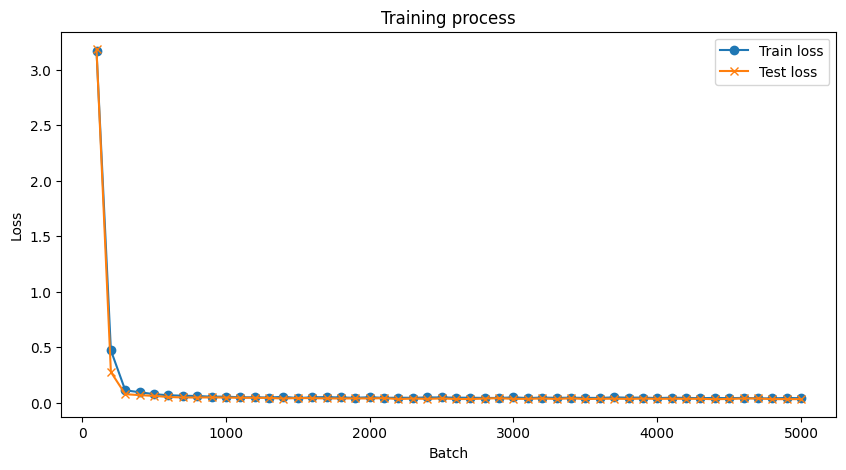

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(batch, train_losses, label="Train loss", marker="o")
plt.plot(batch, test_losses, label="Test loss", marker="x")
plt.title("Training process")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
context = "гаррі сказав герміоні щоб вона швидко зачинила двері які врятували їх від"

context = torch.tensor([encode(context)], dtype=torch.long, device=DEVICE)

answer = decode(model.generate(context, tokens_amt=100)[0].tolist())

print(answer)

гаррі сказав герміоні щоб вона швидко зачинила двері які врятували їх від темних сил він не помер ні та ні дихає прошепотіла герміона і взяла в гаррі тістечко хоч професор люпин і не був надто привітним сусідом але його присутність у купе мала свої переваги пополудні коли за вікном почав іти дощ а пагорби вкрилися мрякою у коридорі знову почулися кроки і в дверях виринули троє найненависніших їм осіб драко мелфой та його приятелі вінсент креб і ґреґорі ґойл драко мелфой і гаррі ворогували ще з першої поїздки до гоґвортсу мелфой що мав бліде гостре і хронічно єхидне обличчя належав до слизеринського гуртожитку він як і гаррі був ловцем своєї команди з


In [14]:
torch.save(model.state_dict(), "model.pth")

In [15]:
print(f"Total Trainable Params: {sum(params.numel() for params in model.parameters() if params.requires_grad)}")

Total Trainable Params: 26320969
